In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
import re

In [2]:
def remove_unwanted(text):
    text=str(text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    return(text)

In [3]:
def remove_stopwords(text):
    text=str(text)
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return(text)

In [4]:
def common_words(text):
    text_tokens=word_tokenize(text)
    fdist=FreqDist()
    for word in text_tokens:
        fdist[word.lower()]+=1
    fdist_10=fdist.most_common(10)
    return(fdist_10)

In [5]:
def convert_to_single_string(text):
    single_text=""
    for i in range(len(text)):
        if(i==0):
            single_text=single_text+text[i]
        else:
            single_text=single_text+" "+text[i]
    return(single_text)

In [6]:
def remove_punctuations(text):
    punctuation_remover=RegexpTokenizer(r'\w+')
    punctuation_remover.tokenize(text)
    return (text)

In [7]:
def lowercase(text):
    return(text.lower())

In [8]:
def lemma(text):
    text_tokens=word_tokenize(text)
    word_lem=WordNetLemmatizer()
    #print(text_tokens)
    lemmatized_text=[]
    i=0
    for word in text_tokens:
        lemmatized_text.append(word_lem.lemmatize(word))
        i+=1
    return(lemmatized_text)

In [9]:
data_df=pd.read_csv(r"D:\Work\Class\Seminar\Propaganda_Dataset_tweets.csv")

In [10]:
data_df.columns=["Source","Indicator","Tweet"]

In [11]:
data_df['Tweet']=data_df['Tweet'].apply(lowercase)
data_df['Tweet']=data_df['Tweet'].apply(remove_unwanted)
data_df['Tweet']=data_df['Tweet'].apply(remove_stopwords)
data_df['Tweet']=data_df['Tweet'].apply(remove_punctuations)
data_df['Tweet']=data_df['Tweet'].apply(lemma)
data_df['Tweet']=data_df['Tweet'].apply(convert_to_single_string)

In [12]:
X=data_df['Tweet']
y=data_df['Indicator'].values

In [13]:
final_dataset=pd.DataFrame({"Indicator":y ,"Tweet":X})

In [14]:
X_train,X_test, y_train,y_test=train_test_split(final_dataset["Tweet"].values,final_dataset["Indicator"].values,test_size=0.2)

In [15]:
tfidfvectorizer = TfidfVectorizer(use_idf=True,sublinear_tf=True)
tfidfvectors_train = tfidfvectorizer.fit_transform(X_train)
tfidfvectors_test  = tfidfvectorizer.transform(X_test)

In [16]:
SVM=svm.SVC(C=1.0, kernel='linear',degree=3,gamma='auto',probability=True)
SVM.fit(tfidfvectors_train,y_train)

SVC(gamma='auto', kernel='linear', probability=True)

In [17]:
scores=cross_val_score(SVM,tfidfvectors_train,y_train,scoring="accuracy",cv=5)

In [18]:
print(scores)

[0.81624826 0.82287308 0.80753138 0.82426778 0.81659693]


In [19]:
pred=SVM.predict(tfidfvectors_test)

In [20]:
prob=SVM.predict_proba(tfidfvectors_test)[:,1]#[:,1]converts it to a 1 d array

In [21]:
pred[200]

1

In [22]:
y_test[200]

1

In [23]:
print(classification_report(y_test,pred))
print('Confusion Matrix:',confusion_matrix(y_test, pred))
fpr, tpr, thresholds = roc_curve(y_test, prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1808
           1       0.86      0.77      0.81      1777

    accuracy                           0.82      3585
   macro avg       0.83      0.82      0.82      3585
weighted avg       0.83      0.82      0.82      3585

Confusion Matrix: [[1591  217]
 [ 414 1363]]
AUC: 0.9044324355954402


In [24]:
print(y_test)

[1 1 0 ... 0 0 0]


In [25]:
print(prob)

[0.34054703 0.99704435 0.03719836 ... 0.85877098 0.06192731 0.5530968 ]


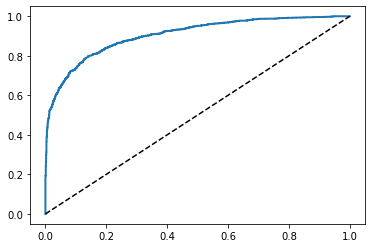

In [26]:
def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
plot_roc_curve(fpr,tpr)
plt.savefig("ROC_Curve_SVM_Prop")
plt.show()


In [27]:
precisions, recalls, thresholds=precision_recall_curve(y_test,pred)

In [28]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds, recalls[:-1],"g--",label="Recall")

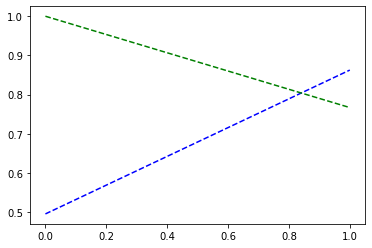

In [29]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.savefig("Precision_Recall_SVM.png")
plt.show()


In [30]:
import pickle

In [31]:
pkl_filename="Prop_SVM"

In [32]:
with open(pkl_filename,"wb") as file:
    pickle.dump(SVM,file)
    